In [1]:
import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, smooth


In [2]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time
from datetime import datetime, timedelta

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
h = np.where(mask_rho, h, np.nan)
angle = dataset.variables['angle'][0, 0]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [3]:
dataset.variables['ocean_time']

<class 'netCDF4._netCDF4.Variable'>
float64 ocean_time(ocean_time)
    long_name: averaged time since initialization
    units: seconds since 1990-01-01 00:00:00
    calendar: proleptic_gregorian
    field: time, scalar, series
unlimited dimensions: ocean_time
current shape = (30,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [4]:
sample_eddies = [5, 722, 2511, 1119, 1460, 1986]
df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,Q11,Q12,Q22,Rc,psi0,Age,fname
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,-0.008769,0.001546,-0.007521,69.500036,70.832145,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,-0.007934,0.000890,-0.007072,52.250752,156.388574,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,-0.006920,0.001050,-0.006852,67.000485,56.418837,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,-0.006959,0.002144,-0.009312,52.001786,31.355771,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,-0.005883,0.001179,-0.008429,56.251116,29.524244,57,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115993,2927,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.002921,0.000642,0.003759,72.751791,-76.302293,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115994,2927,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.002819,0.000983,0.003948,74.250924,-47.064730,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115995,2927,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.002968,0.000566,0.003910,75.750780,-79.414689,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
115996,2927,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.002804,0.000722,0.003863,76.000006,-92.084211,24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


Text(0, 0.5, 'Latitude °N')

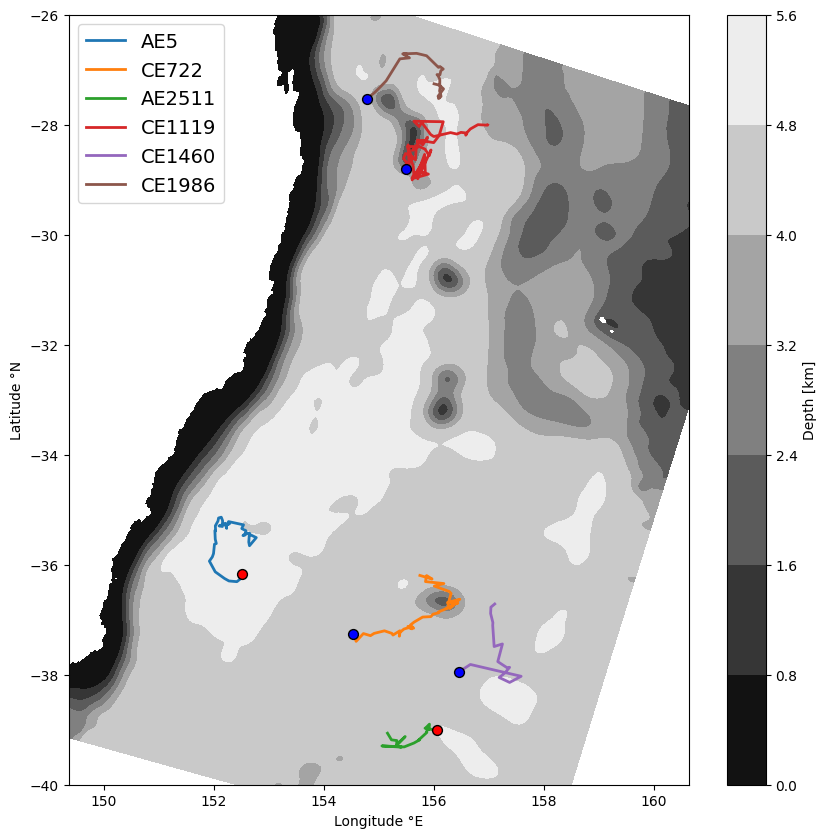

In [5]:
plt.figure(figsize=(10,10))
plt.contourf(lon_rho, lat_rho, h/1000, cmap='gray')
plt.colorbar(label='Depth [km]')

colors = plt.get_cmap('tab10').colors

for e, eddy in enumerate(sample_eddies):
    if e >= 7:
        e += 2
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    cyc = df.iloc[0].Cyc
    plt.plot(df.Lon, df.Lat, label=f'{cyc}{eddy}',
            linewidth=2, color=colors[e])
    plt.scatter(df.iloc[-1]['Lon'], df.iloc[-1]['Lat'], edgecolors='k',
                color='r' if cyc=='AE' else 'b', zorder=10, s=50)

plt.legend(loc='upper left', fontsize=14)
plt.axis('equal')
plt.xlim(150, 160)
plt.ylim(-40, -26)
plt.xlabel('Longitude °E')
plt.ylabel('Latitude °N')



In [6]:
sQ_col = [None] * len(df_eddies)
sRc_col = [np.nan] * len(df_eddies)

for eddy, grp in df_eddies.groupby('Eddy'):
    idx = grp.index.to_list()

    # time axis for smoothing
    ds = np.arange(len(grp))

    q11 = grp['Q11'].to_numpy(float)
    q12 = grp['Q12'].to_numpy(float)
    q22 = grp['Q22'].to_numpy(float)

    Rcs = grp['Rc'].to_numpy(float)

    window = 5  # days
    sq11 = smooth(q11, ds, num=len(ds), window=window)
    sq12 = smooth(q12, ds, num=len(ds), window=window)
    sq22 = smooth(q22, ds, num=len(ds), window=window)
    sRc  = smooth(Rcs, ds, num=len(ds), window=window) 

    # build 2x2 matrix per time step, and write back per row
    sQ_list = [np.array([[a, b], [b, c]], float) for a, b, c in zip(sq11, sq12, sq22)]
    for k, i in enumerate(idx):
        sQ_col[i]  = sQ_list[k]
        sRc_col[i] = sRc[k]

df_eddies['sQ']  = sQ_col
df_eddies['sRc'] = sRc_col


In [ ]:
import os
import matplotlib.patheffects as pe

def GIF_saver(start_day):

    save_dir = "/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Tracking_Images"
    os.makedirs(save_dir, exist_ok=True)
    
    fnumber_old = None
    for day in df_eddies.Day.unique():

        if day >= start_day:

            df_day = df_eddies[df_eddies.Day.eq(day)]

            fname = df_day.iloc[0].fname
        
            fnumber = fname[-8:-3]
        
            if fnumber != fnumber_old:
                u_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/u_{fnumber}.npy')
                v_raw = np.load(f'/srv/scratch/z5297792/Climatology/u_v/v_{fnumber}.npy')
                u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
                v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
                with nc.Dataset(fname) as dataset:
                    ocean_time = dataset.variables['ocean_time'][:].data / 86400
                fnumber_old = fnumber
        
            t_rel = np.where(ocean_time == day)[0][0]
            cs = np.hypot(u_raw[:, :, 0, t_rel], v_raw[:, :, 0, t_rel])
        
            fig, ax = plt.subplots(figsize=(8, 10))
            im = ax.pcolormesh(X_grid, Y_grid, cs, shading='nearest', vmin=0, vmax=2.5)
            fig.colorbar(im, ax=ax, label=r'CS [ms$^{-1}$]')
        
            
            clrs = np.where(df_day.Cyc.eq('CE'), 'c', 'r')
            ax.scatter(df_day.xc, df_day.yc, c=clrs, edgecolors='k', linewidths=0.8, s=60, zorder=10)

            for x, y, e, Q, Rc, cyc in zip(df_day.xc, df_day.yc, df_day.Eddy, df_day.sQ, df_day.sRc, df_day.Cyc):

                x_ell, y_ell = plot_ellipse(Q, (x, y), scale=Rc)
                ax.plot(x_ell, y_ell, color='r' if cyc=='AE' else 'c')

                ax.annotate(
                    str(e), (x, y),
                    textcoords='offset points', xytext=(3, 3),
                    fontsize=12, color='w', weight='bold',
                    path_effects=[pe.withStroke(linewidth=2, foreground='k')],
                    zorder=11
                )
        
            ax.set_title(f'Day {day} | {pd.Timestamp("1990-01-01") + pd.Timedelta(days=day)}')
            ax.set_aspect('equal', adjustable='datalim')
            ax.set_xlabel('x (km)')
            ax.set_ylabel('y (km)')
            ax.set_xlim(x_grid.min(), x_grid.max())
            ax.set_ylim(y_grid.min(), y_grid.max())
        
            out_path = os.path.join(save_dir, f"Day{int(day)}.png")
            fig.savefig(out_path, dpi=150, bbox_inches='tight')
            plt.close(fig)
            
GIF_saver(1462)

